In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')
import numpy as np
import pandas as pd
import os, sys
import warnings
warnings.filterwarnings("ignore")
from geopy.distance import geodesic
from tqdm import tqdm
from typing import List, Tuple, Dict
# switch folder
root_dir = "/Users/jiangxuan/Desktop/beam/test/input/sfbay"
os.chdir(root_dir)
os.getcwd()

'/Users/jiangxuan/Desktop/beam/test/input/sfbay'

# Reconstruction of Logit Model with ActivitySim data

In [2]:
data_dir = os.path.join(root_dir, "gemini/activitysim-plans-base-2010/")
# households
hh = pd.read_csv(os.path.join(data_dir, "households.csv.gz"))
display('Households: ',hh.columns.to_numpy(), hh.head(5))
# parcels (land-use types, useless)
#par = pd.read_csv(os.path.join(data_dir, "parcels.csv.gz"))
#display('Parcel: ', par.columns.to_numpy(), par.head(5))
# persons
per = pd.read_csv(os.path.join(data_dir, "persons.csv.gz"))
display('Persons: ',per.columns.to_numpy(), per.head(5))
# plans
plns = pd.read_csv(os.path.join(data_dir, "plans.csv.gz")).sort_values(by='person_id')
display('Plans: ', plns.columns.to_numpy(), plns.head(5))
# units (useless for modeling)
# unts = pd.read_csv(os.path.join(data_dir, "units.csv.gz"))
# display('Units: ', unts.columns, unts.head(5))

'Households: '

array(['household_id', 'serialno', 'persons', 'cars', 'income',
       'race_of_head', 'age_of_head', 'workers', 'children', 'tenure',
       'recent_mover', 'block_id'], dtype=object)

,household_id,serialno,persons,cars,income,race_of_head,age_of_head,workers,children,tenure,recent_mover,block_id
0,1,2.011001e+12,1,1,131000,1,64,0,0,1,0,60014001001054
1,97,2.010000e+12,2,2,125000,1,50,2,0,1,0,60014001001049
2,193,2.012001e+12,3,2,150800,1,34,1,1,1,0,60014001001026
3,289,2.009001e+12,4,4,300800,1,42,2,2,1,0,60014001001032
4,385,2.009001e+12,2,3,193000,1,47,2,0,1,0,60014001001024


'Persons: '

array(['person_id', 'age', 'earning', 'edu', 'hours', 'household_id',
       'member_id', 'race_id', 'relate', 'sex', 'student', 'work_at_home',
       'worker'], dtype=object)

,person_id,age,earning,edu,hours,household_id,member_id,race_id,relate,sex,student,work_at_home,worker
0,0,64,0,23,0,1,1,1,0,2,0,0,0
1,190,50,25000,22,30,97,1,1,0,2,0,0,1
2,191,50,100000,22,40,97,2,1,13,1,0,0,1
3,379,1,0,0,0,193,3,1,2,2,0,0,0
4,380,34,800,22,10,193,1,1,0,1,0,0,0


'Plans: '

array(['Unnamed: 0', 'trip_id', 'person_id', 'number_of_participants',
       'trip_mode', 'PlanElementIndex', 'ActivityElement', 'ActivityType',
       'x', 'y', 'departure_time'], dtype=object)

,Unnamed: 0,trip_id,person_id,number_of_participants,trip_mode,PlanElementIndex,ActivityElement,ActivityType,x,y,departure_time
0,0,NaN,0.0,NaN,NaN,1,activity,Home,-122.226436,37.855050,11.718
1,1,73.0,0.0,1.0,SHARED2FREE,2,leg,NaN,NaN,NaN,NaN
2,1,NaN,0.0,NaN,NaN,3,activity,escort,-122.076462,37.691972,12.382
3,2,77.0,0.0,1.0,SHARED2PAY,4,leg,NaN,NaN,NaN,NaN
4,2,NaN,0.0,NaN,NaN,5,activity,Home,-122.226436,37.855050,NaN


In [3]:
plns.ActivityType.unique()

array(['Home', nan, 'escort', 'eatout', 'shopping', 'othdiscr', 'school',
       'social', 'othmaint', 'Work', 'atwork', 'work', 'univ'],
      dtype=object)

In [4]:
plns.ActivityType = plns.ActivityType.apply(lambda x: 1 if x in ['work', 'Work'] else (np.nan if x in [np.nan] else 0))

In [5]:
display('Plans: ', plns.columns.to_numpy(), plns.head(5))

'Plans: '

array(['Unnamed: 0', 'trip_id', 'person_id', 'number_of_participants',
       'trip_mode', 'PlanElementIndex', 'ActivityElement', 'ActivityType',
       'x', 'y', 'departure_time'], dtype=object)

,Unnamed: 0,trip_id,person_id,number_of_participants,trip_mode,PlanElementIndex,ActivityElement,ActivityType,x,y,departure_time
0,0,NaN,0.0,NaN,NaN,1,activity,0.0,-122.226436,37.855050,11.718
1,1,73.0,0.0,1.0,SHARED2FREE,2,leg,NaN,NaN,NaN,NaN
2,1,NaN,0.0,NaN,NaN,3,activity,0.0,-122.076462,37.691972,12.382
3,2,77.0,0.0,1.0,SHARED2PAY,4,leg,NaN,NaN,NaN,NaN
4,2,NaN,0.0,NaN,NaN,5,activity,0.0,-122.226436,37.855050,NaN


In [6]:
length = len(plns[plns.ActivityElement=='activity'])

In [7]:
plns.ActivityType.sum(skipna=True) / length

0.13480273042870258

In [8]:
plns = plns.drop(axis=0, index=0)

In [9]:
plns.ActivityType.unique()

array([nan,  0.,  1.])

In [10]:
plns['dropOrNot'] = 2

In [11]:
plns.iloc[169]

Unnamed: 0                      93
trip_id                     7205.0
person_id                     21.0
number_of_participants         1.0
trip_mode                 WALK_LRF
PlanElementIndex                 8
ActivityElement                leg
ActivityType                   NaN
x                              NaN
y                              NaN
departure_time                 NaN
dropOrNot                        2
Name: 165, dtype: object

In [12]:
indexes = []
plns = plns.reset_index(drop=True)
for indx, row in plns.iterrows():
    if row.ActivityType == 1:
        ref_elems = plns.loc[indx+1, 'ActivityElement']
        if ref_elems == 'leg':
            indexes.extend([indx, indx+1])
        else:
            indexes.append(indx)

In [13]:
plns.iloc[indexes]

,Unnamed: 0,trip_id,person_id,number_of_participants,trip_mode,PlanElementIndex,ActivityElement,ActivityType,x,y,departure_time,dropOrNot
170,92,NaN,21.0,NaN,NaN,7,activity,1.0,-122.186791,37.728855,15.851,2
171,92,6.893000e+03,21.0,1.0,SHARED2FREE,6,leg,NaN,NaN,NaN,NaN,2
174,90,NaN,21.0,NaN,NaN,3,activity,1.0,-122.230618,37.854909,12.343,2
175,90,7.201000e+03,21.0,1.0,WALK_HVY,2,leg,NaN,NaN,NaN,NaN,2
289,159,NaN,31.0,NaN,NaN,3,activity,1.0,-122.058357,37.959513,18.692,2
...,...,...,...,...,...,...,...,...,...,...,...,...
53229539,29622282,NaN,6741456.0,NaN,NaN,3,activity,1.0,-122.537841,37.998614,18.083,2
53229540,29622283,2.211198e+09,6741456.0,1.0,DRIVE_LOC,4,leg,NaN,NaN,NaN,NaN,2
53229546,29622285,NaN,6741457.0,NaN,NaN,3,activity,1.0,-121.920910,37.376578,17.674,2
53229563,29622297,NaN,6741460.0,NaN,NaN,3,activity,1.0,-122.712832,38.497878,16.994,2


## Preprocessing Plans data

In [20]:
plns

,Unnamed: 0,trip_id,person_id,number_of_participants,trip_mode,PlanElementIndex,ActivityElement,ActivityType,x,y,departure_time,dropOrNot
0,1,7.300000e+01,0.0,1.0,SHARED2FREE,2,leg,NaN,NaN,NaN,NaN,2
1,1,NaN,0.0,NaN,NaN,3,activity,0.0,-122.076462,37.691972,12.382,2
2,2,7.700000e+01,0.0,1.0,SHARED2PAY,4,leg,NaN,NaN,NaN,NaN,2
3,2,NaN,0.0,NaN,NaN,5,activity,0.0,-122.226436,37.855050,NaN,2
4,10,NaN,1.0,NaN,NaN,15,activity,0.0,-122.226436,37.855050,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...
53229580,29622300,NaN,6741461.0,NaN,NaN,3,activity,0.0,-122.408397,37.790166,10.072,2
53229581,29622300,2.211199e+09,6741461.0,1.0,WALK_LOC,2,leg,NaN,NaN,NaN,NaN,2
53229582,29622299,NaN,6741461.0,NaN,NaN,1,activity,0.0,-123.061499,38.350591,9.295,2
53229583,29622303,2.211199e+09,6741461.0,1.0,TNC_SINGLE,8,leg,NaN,NaN,NaN,NaN,2


In [25]:
# Calculate distance
dist = []
ref_id = 0
for i in tqdm(range(len(plns)-1)):
    if plns.person_id[i]==ref_id and plns.person_id[i+1]==ref_id:
        if plns.ActivityElement[i]=='leg':
            x_1, y_1 = plns.x[i], plns.y[i]
            x_2, y_2 = plns.x[i+1], plns.y[i+1]
            dist.append(geodesic((y_1, x_1), (y_2,x_2)).min)
        else:
            dist.append(np.nan)
    else:
        ref_id = plns.person_id[i]
        dist.append(np.nan)
dist.append(np.nan)
plns['distance']=dist
display(plns.distance.unique())

  0%|          | 0/53229584 [00:00<?, ?it/s]


ValueError: Point coordinates must be finite. (nan, nan, 0.0) has been passed as coordinates.

In [17]:
# encode mode
plns_proc = plns.dropna(subset=['trip_mode'])
mode_map = {
        "BIKE": 0,
        "DRIVEALONEFREE": 1,
        "DRIVEALONEPAY": 1,
        "DRIVE_COM": 2,
        "DRIVE_EXP": 2,
        "DRIVE_HVY": 2,
        "DRIVE_LOC": 2,
        "DRIVE_LRF": 2,
        "SHARED2FREE": 1,
        "SHARED2PAY": 1,
        "SHARED3FREE": 1,
        "SHARED3PAY": 1,
        "TAXI": 3,
        "TNC_SHARED": 3,
        "TNC_SINGLE": 3,
        "WALK": 4,
        "WALK_COM": 5,
        "WALK_EXP": 5,
        "WALK_HVY": 5,
        "WALK_LOC": 5,
        "WALK_LRF": 5,
}
plns_proc.trip_mode = plns_proc.trip_mode.apply(lambda x: mode_map[x])
print("After mapping, only %d of data persisted" % len(plns_proc))
plns_proc.head(5)

After mapping, only 23607278 of data persisted


,Unnamed: 0,trip_id,person_id,number_of_participants,trip_mode,PlanElementIndex,ActivityElement,ActivityType,x,y,departure_time,dropOrNot
0,1,73.0,0.0,1.0,1,2,leg,NaN,NaN,NaN,NaN,2
2,2,77.0,0.0,1.0,1,4,leg,NaN,NaN,NaN,NaN,2
5,10,535.0,1.0,1.0,1,14,leg,NaN,NaN,NaN,NaN,2
7,9,534.0,1.0,1.0,1,12,leg,NaN,NaN,NaN,NaN,2
9,8,533.0,1.0,1.0,3,10,leg,NaN,NaN,NaN,NaN,2


## Join datasets

In [15]:
ref_list = plns.person_id.astype(int)
joinable_id = []
# extract joinable ids
for id_ in per.person_id:
    if id_ in ref_list:
        joinable_id.append(id_)
print("Joinable" if len(joinable_id)>0 else "Unjoinable")
print(len(joinable_id))
del joinable_id

Joinable
6741462


In [19]:
# pln_attrs = ['person_id', 'trip_mode', 'distance']
pln_attrs = ['person_id', 'trip_mode']
drop_cols = ['Unnamed: 0_x', 'Unnamed: 0_y', 'serialno', 
                 'person_id', 'household_id', 'recent_mover', 'block_id',
                    'member_id', 'relate', 'workers', 'children',
                        'race_of_head', 'age_of_head']
per_hh = pd.merge(hh, per, on='household_id')
data = pd.merge(plns_proc[pln_attrs], per_hh, on='person_id')
# filter
data = data[data.age>=16]
data = data.drop(drop_cols, axis=1)
data = data.dropna()
# Add travel time approximation
vf_map = {0: 10, 1: 30, 2: 20, 3: 30, 4: 2.25, 5: 2.25}
data['travel_time'] = data.distance.div(data.trip_mode.apply(lambda x: vf_map[x]))

display(data.head(5))
data.to_csv(os.path.join(root_dir, "./cleaned_joint_data.csv"), sep=',', encoding='utf-8')

KeyboardInterrupt: 

In [ ]:
data = pd.read_csv(os.path.join(root_dir, "./cleaned_joint_data.csv"), sep=',', encoding='utf-8')
vf_map = {0: 10, 1: 30, 2: 20, 3: 30, 4: 2.25, 5: 2.25}
data['travel_time'] = data.distance.div(data.trip_mode.apply(lambda x: vf_map[x]))
data.to_csv(os.path.join(root_dir, "./cleaned_joint_data.csv"), sep=',', encoding='utf-8')

In [6]:
del data

## Logit Model

$\rightarrow$ (1) calaulate distance
$\rightarrow$ (2) map modes
$\rightarrow$ (3) fit multinomial logit by (Maximum likelihood loss)


Given $y \in \mathbb{R}$, 
$V=\alpha + \beta^{\top} t$


$\alpha \in \mathbb{R}^{m}$

$\beta \in \mathbb{R}^{k * m}$


$t \in \mathbb{R}^{k x 1}$


$v \in \mathbb{R}^{m} \rightarrow$ utility of m modes


$(\beta, \alpha) \text { <-> } V \text { <-> } softmax(V) \text { <-> } \hat{y} \text { <-> } \text {Entropy Loss }$


$softmax(V):$ $\sigma(\vec{v})_{i}=\frac{e^{v_{i}}}{\sum_{j=1}^{K} e^{v_{j}}}$

$\text {Entropy Loss }=-\sum_{i=1}^{\text {output size}} y_{i} \cdot \log \hat{y}_{i}$

### Neural Network approximation via Pytorch

In [7]:
import torch as T
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class SF_Dataset(Dataset):
    def __init__(self, dat_dir: str, use_cols: list, label: str='train', 
                     one_hot: bool=True, norm: str=None) -> None:
        super(SF_Dataset, self).__init__()
        self.data = pd.read_csv(dat_dir, sep=',', usecols=use_cols, encoding='utf-8')
        self.X = self.data.loc[:, self.data.columns!='trip_mode'].to_numpy()
        self.y = self.data.trip_mode.to_numpy()
        self.in_dim, self.out_dim = self.X.shape[1], 6
        self.len = len(self.y)
        if one_hot:
            self.y = self.one_hot_encode(self.y, 6)
        if norm in ['maxmin', 'zscore']:
            if norm == 'maxmin':
                rng = np.max(self.X, axis=0)-np.min(self.X, axis=0)
                self.X = (self.X - np.min(self.X, axis=0)) / rng
            if norm == 'zscore':
                self.X = (self.X - np.mean(self.X, axis=0)) / np.std(test, axis=0)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if T.is_tensor(idx):
            idx = idx.tolist()
        
        attributes = self.X[idx, :]
        attributes = T.from_numpy(attributes).float()

        mode = self.y[idx]
        mode = T.from_numpy(np.array(mode)).long()
        return attributes, mode
    
    def one_hot_encode(self, int_mode: np.ndarray, total: int):
        res = []
        for k in int_mode:
            empty_choice = np.zeros(total)
            empty_choice[k] += 1
            res.append(empty_choice)
        return np.array(res)

In [8]:
# neural network
# the initial value is picked randomly from normal distribution
class MultiLogit(nn.Module):
    def __init__(self, in_dim: int, out_dim: int) -> None:
        super(MultiLogit, self).__init__()
        self.lyrs = nn.Linear(in_dim, out_dim)
    
    def forward(self, x: T.Tensor) -> T.Tensor:
        x = x.float()
        out = self.lyrs(x)
        # out = nn.functional.softmax(out)
        return out

100%|██████████| 10/10 [17:38<00:00, 105.81s/it]


{'β': array([[ 3.0962348e-02, -9.0478522e-01],
        [-2.2684519e-01, -5.1047272e+01],
        [ 7.7441615e-01, -2.1407361e+00],
        [-2.9537101e+00, -5.6265079e+01],
        [ 3.8820961e-01,  2.4912903e+01],
        [ 3.6607665e-01,  2.8332144e+01]], dtype=float32),
 'α': array([-2.9049432,  1.7486267, -1.2205821, -0.3485046, -1.8159534,
        -1.4235219], dtype=float32)}

100%|██████████| 39062/39062 [02:02<00:00, 318.70it/s]

{'acc1': 0.7457895977563264}


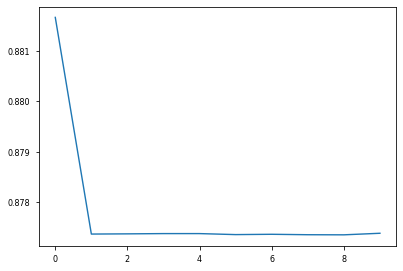

In [9]:
# Top-k accuracy = # total right / # total
def topk_accuracy(outputs: T.Tensor, targets: T.Tensor, topk: Tuple[int]=(1,)) -> Dict:
    maxk = max(topk)
    batch_size = targets.size(0)

    _, preds = outputs.topk(maxk, 1, True, True)
    preds = preds.t()

    # for one-hot encoding
    if targets.ndimension() > 1:
        targets = targets.max(1)[1]

    correct = preds.eq(targets.view(1, -1).expand_as(preds))

    res = dict()
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res["acc{}".format(k)] = correct_k.mul_(1.0 / batch_size).item()
    return res
# training
batch_size, epochs, lr = 256, 10, 0.025
train_data = SF_Dataset(os.path.join(root_dir, "./cleaned_joint_data.csv"), 
                            use_cols=['earning', 'travel_time','trip_mode'], one_hot=False,
                               norm='maxmin')
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
model = MultiLogit(train_data.in_dim, train_data.out_dim)
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
#lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=1e-3)
losses = []
for _ in tqdm(range(epochs)):
    epoch_loss = 0
    for step, (x, y_tgt) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y_tgt)
        loss.backward()
        optimizer.step()
        #lr_scheduler.step()
        epoch_loss += loss.detach().data
    losses.append(epoch_loss/(step+1))
plt.plot(np.arange(epochs), losses)
display({name:p  for name, p in zip(
    ['β', 'α'], [param.data.numpy() for param in model.parameters()]
)})

# Calculate accuracy
model.eval()
mean_top_k = dict()
for x, y_tgt in tqdm(train_loader):
    y_pred = model(x)
    y_pred = nn.functional.softmax(y_pred)
    for k, v in topk_accuracy(y_pred, y_tgt).items():
        if not k in mean_top_k.keys():
            mean_top_k[k] = list()
        mean_top_k[k].append(v)
print({k: np.mean(v) for k, v in mean_top_k.items()})

In [ ]:
# mode_map = {
#         "BIKE": 0,
#         "DRIVEALONEFREE": 1,
#         "DRIVEALONEPAY": 1,
#         "DRIVE_COM": 2,
#         "DRIVE_EXP": 2,
#         "DRIVE_HVY": 2,
#         "DRIVE_LOC": 2,
#         "DRIVE_LRF": 2,
#         "SHARED2FREE": 1,
#         "SHARED2PAY": 1,
#         "SHARED3FREE": 1,
#         "SHARED3PAY": 1,
#         "TAXI": 3,
#         "TNC_SHARED": 3,
#         "TNC_SINGLE": 3,
#         "WALK": 4,
#         "WALK_COM": 5,
#         "WALK_EXP": 5,
#         "WALK_HVY": 5,
#         "WALK_LOC": 5,
#         "WALK_LRF": 5,
# }

### Approximation via Sklearn